In [1]:
# ! pip install -e .

In [2]:
input="/app/data/outputs/2024.09.26/21.36.41_train_diffusion_unet_image_first_task/checkpoints/latest.ckpt"
output="/app/data/outputs/2024.09.26/20.43.00_train_diffusion_unet_image_first_task/checkpoints/output"
robot_ip="192.168.0.204"
match_dataset="/app/data/pusht_real/real_pusht_20230105"
match_episode=None
vis_camera_idx=0
init_joints=False
steps_per_inference=6
max_duration=60
frequency=10
command_latency=0.01

In [3]:
import sys
sys.path.append("/opt/ros/noetic/lib/python3/dist-packages")
sys.path.append("/app/diffusion_policy/real_world/dynamic_biped_ws/devel/lib/python3/dist-packages")


In [4]:
!source /app/diffusion_policy/real_world/dynamic_biped_ws/devel/setup.zsh

In [5]:
import rospkg
import rospy

In [6]:
import time
from multiprocessing.managers import SharedMemoryManager
import click
import cv2
import numpy as np
import torch
import dill
import hydra
import pathlib
import skvideo.io
from omegaconf import OmegaConf
import scipy.spatial.transform as st
from diffusion_policy.real_world.real_env_kuavo import KuavoEnv
# from diffusion_policy.real_world.spacemouse_shared_memory import Spacemouse
from diffusion_policy.common.precise_sleep import precise_wait
from diffusion_policy.real_world.real_inference_util import (
    get_real_obs_resolution, 
    get_real_obs_dict)
from diffusion_policy.common.pytorch_util import dict_apply
from diffusion_policy.workspace.base_workspace import BaseWorkspace
from diffusion_policy.policy.base_image_policy import BaseImagePolicy
from diffusion_policy.common.cv2_util import get_image_transform

/root/miniconda3/envs/robodiff/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# load match_dataset
match_camera_idx = 0
episode_first_frame_map = dict()
if match_dataset is not None:
    match_dir = pathlib.Path(match_dataset)
    match_video_dir = match_dir.joinpath('videos')
    for vid_dir in match_video_dir.glob("*/"):
        episode_idx = int(vid_dir.stem)
        match_video_path = vid_dir.joinpath(f'{match_camera_idx}.mp4')
        if match_video_path.exists():
            frames = skvideo.io.vread(
                str(match_video_path), num_frames=1)
            episode_first_frame_map[episode_idx] = frames[0]
        break
print(f"Loaded initial frame for {len(episode_first_frame_map)} episodes")

Loaded initial frame for 1 episodes


In [8]:
import os
os.environ['http_proxy'] = 'http://172.17.0.1:7890'
os.environ['https_proxy'] = 'http://172.17.0.1:7890'

In [9]:
# load checkpoint
ckpt_path = input
payload = torch.load(open(ckpt_path, 'rb'), pickle_module=dill)
cfg = payload['cfg']
cls = hydra.utils.get_class(cfg._target_)
workspace = cls(cfg)
workspace: BaseWorkspace
workspace.load_payload(payload, exclude_keys=None, include_keys=None)

In [10]:
# hacks for method-specific setup.
action_offset = 0
delta_action = False
if 'diffusion' in cfg.name:
    # diffusion model
    policy: BaseImagePolicy
    policy = workspace.model
    if cfg.training.use_ema:
        policy = workspace.ema_model
    device = torch.device('cuda')
    policy.eval().to(device)
    # set inference params
    policy.num_inference_steps = 16 # DDIM inference iterations
    policy.n_action_steps = 32
elif 'robomimic' in cfg.name:
    # BCRNN model
    policy: BaseImagePolicy
    policy = workspace.model
    device = torch.device('cuda')
    policy.eval().to(device)
    # BCRNN always has action horizon of 1
    steps_per_inference = 1
    action_offset = cfg.n_latency_steps
    delta_action = cfg.task.dataset.get('delta_action', False)
elif 'ibc' in cfg.name:
    policy: BaseImagePolicy
    policy = workspace.model
    policy.pred_n_iter = 5
    policy.pred_n_samples = 4096
    device = torch.device('cuda')
    policy.eval().to(device)
    steps_per_inference = 1
    action_offset = 1
    delta_action = cfg.task.dataset.get('delta_action', False)
else:
    raise RuntimeError("Unsupported policy type: ", cfg.name)

In [11]:
# setup experiment
dt = 1/frequency
print(cfg)
obs_res = get_real_obs_resolution(cfg.task.shape_meta)
n_obs_steps = cfg.n_obs_steps
print("n_obs_steps: ", n_obs_steps)
print("steps_per_inference:", steps_per_inference)
print("action_offset:", action_offset)
print('n_action_steps', cfg.n_action_steps)

{'name': 'train_diffusion_unet_image', '_target_': 'diffusion_policy.workspace.train_diffusion_unet_image_workspace.TrainDiffusionUnetImageWorkspace', 'task_name': 'first_task', 'shape_meta': {'obs': {'image': {'shape': [3, 96, 96], 'type': 'rgb'}, 'agent_pos': {'shape': [7], 'type': 'low_dim'}}, 'action': {'shape': [7]}}, 'exp_name': 'default', 'horizon': 16, 'n_obs_steps': 2, 'n_action_steps': 8, 'n_latency_steps': 0, 'dataset_obs_steps': 2, 'past_action_visible': False, 'keypoint_visible_rate': 1.0, 'obs_as_global_cond': True, 'policy': {'_target_': 'diffusion_policy.policy.diffusion_unet_image_policy.DiffusionUnetImagePolicy', 'shape_meta': {'obs': {'image': {'shape': [3, 96, 96], 'type': 'rgb'}, 'agent_pos': {'shape': [7], 'type': 'low_dim'}}, 'action': {'shape': [7]}}, 'noise_scheduler': {'_target_': 'diffusers.schedulers.scheduling_ddim.DDIMScheduler', 'num_train_timesteps': 100, 'beta_start': 0.0001, 'beta_end': 0.02, 'beta_schedule': 'squaredcos_cap_v2', 'clip_sample': True, '

In [12]:
env = KuavoEnv(
        output_dir=output,
        frequency=frequency,
        n_obs_steps=2,
        obs_image_resolution=(640, 480),
        max_obs_buffer_size=30,
        robot_publish_rate=125,
        video_capture_fps=30,
        video_capture_resolution=(1280, 720),
        )
    

In [13]:
fake_obs=env.get_fake_obs()
for k, v in fake_obs.items():
    print(k, v.shape)
ckpt_check_folder = '/app/data/outputs/2024.09.26/21.36.41_train_diffusion_unet_image_first_task/test'
os.makedirs(ckpt_check_folder, exist_ok=True)

image (2, 480, 640, 3)
agent_pos (2, 7)
timestamp (2,)


In [19]:

try:
    # start episode
    policy.reset()
    start_delay = 1.0
    eval_t_start = time.time() + start_delay
    t_start = time.monotonic() + start_delay
    # env.start_episode(eval_t_start)
    # wait for 1/30 sec to get the closest frame actually
    # reduces overall latency
    frame_latency = 1/30
    precise_wait(eval_t_start - frame_latency, time_func=time.time)
    print("Started!")
    iter_idx = 0
    term_area_start_timestamp = float('inf')
    perv_target_pose = None
    gripper_state=[]
    while True:
        # calculate timing
        t_cycle_end = t_start + (iter_idx + steps_per_inference) * dt
        # get obs
        print('get_obs')
        # obs = env.get_obs()
        obs = env.get_fake_obs()
        for k, v in obs.items():
            print(k, v.shape)
        obs_timestamps = obs['timestamp']
        print(f'Obs latency {time.time() - obs_timestamps[-1]}')
        # run inference
        with torch.no_grad():
            s = time.time()
            obs_dict_np = get_real_obs_dict(
                env_obs=obs, shape_meta=cfg.task.shape_meta)
            obs_dict = dict_apply(obs_dict_np, 
                lambda x: torch.from_numpy(x).unsqueeze(0).to(device))
            result = policy.predict_action(obs_dict)
            # this action starts from the first obs step
            action = result['action'][0].detach().to('cpu').numpy()
            print('Inference latency:', time.time() - s)
        
        # # clip actions
        # this_target_poses[:,:2] = np.clip(
        #     this_target_poses[:,:2], [0.25, -0.45], [0.77, 0.40])
        # execute actions
        
        # 计算action每一维的均值
        env.exec_fake_actions(
            actions=action,
        )
        break
        
except KeyboardInterrupt:
    print("Interrupted!")
    # stop robot.
    env.end_episode()

Started!
get_obs
image (2, 480, 640, 3)
agent_pos (2, 7)
timestamp (2,)
Obs latency -0.08920550346374512
Inference latency: 0.20783162117004395
executing actions: (15, 7)


In [ ]:
import cv2
import zarr
import numpy as np
import matplotlib.pyplot as plt

video_folder = "/app/data/BJ_juice1/video"
os.makedirs(ckpt_check_folder+"video.mp4", exist_ok=True)

os.makedirs(video_folder,exist_ok=True)
    
# test a episode
dataset_path = "/app/data/BJ_juice1/zarr/BJ_juice1.zarr"
dataset_root = zarr.open(dataset_path, 'r')
# dataset_root0 = zarr.open(dataset_path0, 'r')
print(dataset_root.tree())

train_image_data = dataset_root['data']['img']
# train_image_data = np.moveaxis(train_image_data, -1, 1)
train_data = {    
    'image':train_image_data,
    'agent_pos': dataset_root['data']['state'],
    'action': dataset_root['data']['action']
}
episode_ends = dataset_root['meta']['episode_ends'][:10]

# plot first 10 episodes and record the video
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(1):
    start_idx = 0
    if i > 0:
        start_idx = episode_ends[i-1]
    end_idx = episode_ends[i]
    episode_length = end_idx - start_idx
    ax = axs[i//5, i%5]
    ax.set_title(f"Episode {i}")
    
    obs_sequencia = {
        'image': train_data['image'][start_idx:end_idx],
        'agent_pos': train_data['agent_pos'][start_idx:end_idx],   
    }
    act_sequencia = train_data['action'][start_idx:end_idx]
    print(f"Episode {i} length: {episode_length}")
    
    # ===================predict horizon actions with n_obs_steps observations===================
    import tqdm
    pred_actions, true_actions,true_states = [], [], []
    images = obs_sequencia['image']
    agent_poses = obs_sequencia['agent_pos']
    actions = act_sequencia
    WINDOW_SIZE = n_obs_steps
    for step in tqdm.trange(len(images) - (WINDOW_SIZE - 1)):
        input_images = np.stack(images[step:step+WINDOW_SIZE])
        input_agent_poses = np.stack(agent_poses[step:step+WINDOW_SIZE])
        obs = {
            'image': input_images,
            'agent_pos': input_agent_poses
        }
        # run inference
        with torch.no_grad():
            s = time.time()
            obs_dict_np = get_real_obs_dict(
                env_obs=obs, shape_meta=cfg.task.shape_meta)
            obs_dict = dict_apply(obs_dict_np, 
                lambda x: torch.from_numpy(x).unsqueeze(0).to(device))
            result = policy.predict_action(obs_dict)
            # this action starts from the first obs step
            action = result['action'][0].detach().to('cpu').numpy()
            # print('Inference latency:', time.time() - s)
            
        pred_actions.append(action) # (horizon, action_dim)
        final_window_step = step + WINDOW_SIZE - 1
        true_actions.append(np.array(actions[final_window_step]))
        true_states.append(np.array(agent_poses[final_window_step]))
        
    ax.plot(train_data['agent_pos'][start_idx:end_idx,0], label='Agent Position')
    ax.plot(train_data['action'][start_idx:end_idx,0], label='Action')
    # 保证每张图之间的x轴刻度一致,y轴刻度一致,y轴一格为50。而且每个图的50长度是一样的
    ax.set_xticks(np.arange(0, 200, 50))
    ax.set_yticks(np.arange(0, 0.2, 0.05))
    # ax.set_aspect('equal')
    ax.legend()
    
    # 提取帧数据
    frames = train_image_data[start_idx:end_idx]
    # frames = np.moveaxis(frames, 1, -1)  # 确保帧数据格式为 (height, width, channels)
    frames = frames.astype(np.uint8)

    # 存储为MP4文件
    video_path = os.path.join(video_folder, f"episode_{i}.mp4")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 使用mp4编码
    out = cv2.VideoWriter(video_path, fourcc, 10, (frames.shape[2], frames.shape[1]))  # 设置帧速率和帧大小
    
    for frame in frames:
        out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # 将RGB转换为BGR格式
    out.release()
    
    

plt.tight_layout()
plt.show()


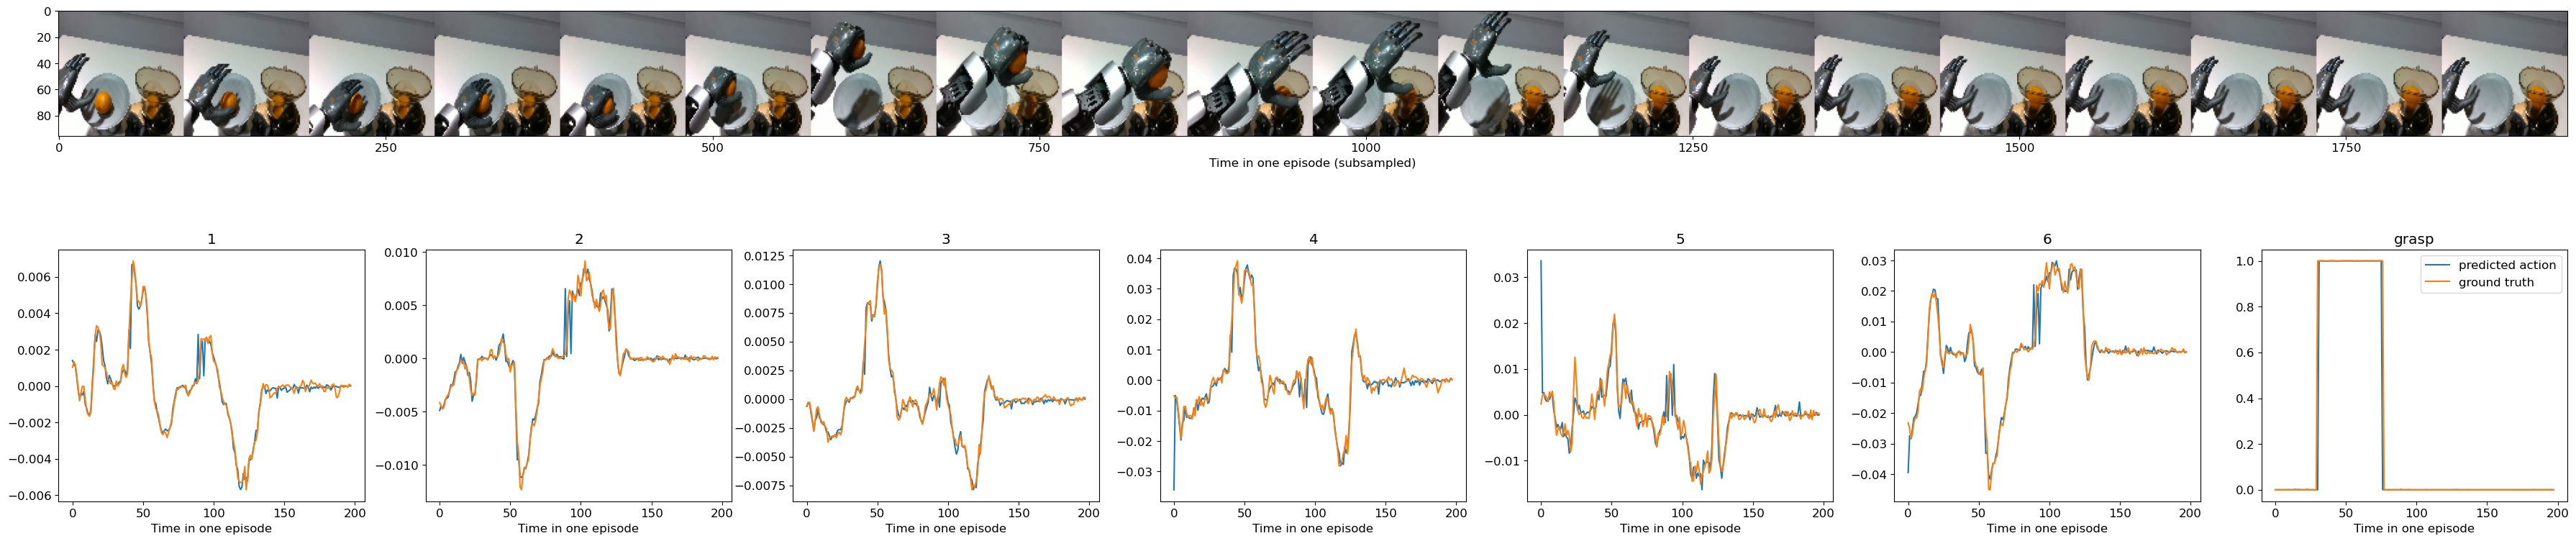

In [29]:
import matplotlib.pyplot as plt

ACTION_DIM_LABELS = ['1', '2', '3', '4', '5', '6','grasp']

# build image strip to show above actions
img_strip = np.concatenate(np.array(images[::10]), axis=1)

# set up plt figure
figure_layout = [
    ['image'] * len(ACTION_DIM_LABELS),
    ACTION_DIM_LABELS
]

plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplot_mosaic(figure_layout)
fig.set_size_inches([45, 10])

# plot actions
pred_actions = np.array(pred_actions).squeeze()
true_actions = np.array(true_actions).squeeze()
true_states=np.array(true_states).squeeze()
for action_dim, action_label in enumerate(ACTION_DIM_LABELS):
  # actions have batch, horizon, dim, in this example we just take the first action for simplicity
  axs[action_label].plot(pred_actions[:, 0, action_dim], label='predicted action')
  axs[action_label].plot(true_actions[:, action_dim], label='ground truth')
  # axs[action_label].plot(true_states[:, action_dim], label='ground truth state')
  axs[action_label].set_title(action_label)
  axs[action_label].set_xlabel('Time in one episode')

axs['image'].imshow(img_strip)
axs['image'].set_xlabel('Time in one episode (subsampled)')
plt.legend()

1. octo l1ActionHead
![alt text](image.png)

2. diffusion
![alt text](image-1.png)